In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
# 获取当前文件所在的文件夹路径
if "__file__" in globals():
    # 获取__file__变量的值
    file_path = __file__
    # 获取当前文件所在的文件夹路径
    dir_now = os.path.dirname(file_path)
else:
    # 获取当前工作目录
    dir_now = os.getcwd()
sys.path.append(os.path.join(dir_now, '../../'))
sys.path.append(os.path.join(dir_now, '../'))
from NNutils import *
from amm_methods import *

## 统计数据集

In [9]:
linear_name = 'etl2'
feedback_bits = 256
linear_name_full = "ex_linear2"
method = METHOD_MITHRAL
ncodebooks = 256 # max:512
ncentroids = 32
train_sam_num = 1000 # 训练集样本数
test_sam_num = 1000


In [10]:
AMM_train_dirs = get_AMM_train_dirs(linear_name, linear_name_full, method, feedback_bits, train_sam_num, test_sam_num)
train_data = np.load(os.path.join(AMM_train_dirs["dir_train"],AMM_train_dirs["linearin_path_train"]))
test_data = np.load(os.path.join(AMM_train_dirs["dir_test"],AMM_train_dirs["linearin_path_test"]))

In [16]:
D = train_data.shape[1]
DC = int(D / ncodebooks)
n = 0
train_data_n_cb = train_data[:,n*DC:(n+1)*DC]


In [19]:
# get the max and min values of the matrix
max_value = train_data_n_cb.max()
min_value = train_data_n_cb.min()
print(max_value)
print(min_value)

0.42258874
0.0


In [26]:
# create a boolean mask by comparing with zero
mask = train_data_n_cb != 0

# apply the mask to filter out zero elements
train_data_n_cb_no0 = train_data_n_cb[mask]


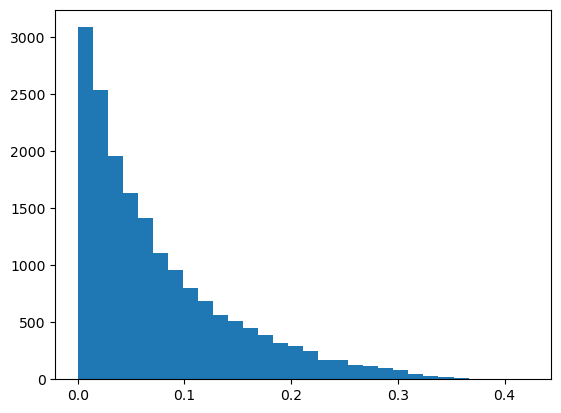

In [27]:

# plot a histogram of the matrix elements with 10 bins
plt.hist(train_data_n_cb_no0.flatten(), bins=30, range=(min_value, max_value))
plt.show()

## 统计质心

In [ ]:
centroid = np.load()


TypeError: load() missing 1 required positional argument: 'file'